In [140]:
import json
import os
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
from itertools import combinations, chain
from scipy.stats import pearsonr
from scipy.spatial.distance import cdist
import numpy as np
import pandas as pd
from math import pow, log10
import seaborn as sns


In [131]:
%matplotlib inline

In [2]:
case_advs_path = "/home/workboots/Datasets/DHC/variations/new/var_4/targets/dropped/case_advs.json"
case_areas_path = "/home/workboots/Datasets/DHC/variations/new/var_4/targets/with_areas/balanced_label_targets.json"
area_num_path = "/home/workboots/Datasets/DHC/variations/new/var_4/area_act_chapter_section_info/dropped/train/area_case_num.json"
area_num_overall_path = "/home/workboots/Datasets/DHC/variations/new/var_4/area_act_chapter_section_info/dropped/overall/area_case_num.json"
selected_advs_path = "/home/workboots/Datasets/DHC/variations/new/var_4/targets/dropped/selected_advs.txt"

In [3]:
with open(case_advs_path, 'r') as f:
    case_advs = json.load(f)

In [4]:
with open(case_areas_path, 'r') as f:
    case_areas = json.load(f)

In [5]:
with open(area_num_path, 'r') as f:
    area_num = json.load(f)

In [6]:
with open(selected_advs_path, 'r') as f:
    selected_advs = f.readlines()
selected_advs = list(filter(None, map(lambda x: x.strip("\n"), selected_advs)))

In [7]:
adv_info_overall_path = "/home/workboots/Datasets/DHC/variations/new/var_4/adv_info/dropped/overall/adv_area_act_chapter_section_info.json"
adv_info_train_path = "/home/workboots/Datasets/DHC/variations/new/var_4/adv_info/dropped/train/adv_area_act_chapter_section_info.json"
adv_info_test_path = "/home/workboots/Datasets/DHC/variations/new/var_4/adv_info/dropped/test/adv_area_act_chapter_section_info.json"
adv_info_validation_path = "/home/workboots/Datasets/DHC/variations/new/var_4/adv_info/dropped/validation/adv_area_act_chapter_section_info.json"
adv_case_num_path = "/home/workboots/Datasets/DHC/variations/new/var_4/adv_info/dropped/train/adv_case_num.json"
adv_case_num_overall_path = "/home/workboots/Datasets/DHC/variations/new/var_4/adv_info/dropped/overall/adv_case_num.json"

In [8]:
case_info_overall_path = "/home/workboots/Datasets/DHC/variations/new/var_4/area_act_chapter_section_info/dropped/overall/case_area_act_chapter_section_info.json"
case_info_train_path = "/home/workboots/Datasets/DHC/variations/new/var_4/area_act_chapter_section_info/dropped/train/case_area_act_chapter_section_info.json"
case_info_test_path = "/home/workboots/Datasets/DHC/variations/new/var_4/area_act_chapter_section_info/dropped/test/case_area_act_chapter_section_info.json"
case_info_validation_path = "/home/workboots/Datasets/DHC/variations/new/var_4/area_act_chapter_section_info/dropped/validation/case_area_act_chapter_section_info.json"
case_case_num_path = "/home/workboots/Datasets/DHC/variations/new/var_4/area_act_chapter_section_info/dropped/train/case_case_num.json"
case_case_num_overall_path = "/home/workboots/Datasets/DHC/variations/new/var_4/area_act_chapter_section_info/dropped/overall/case_case_num.json"

In [9]:
with open(adv_case_num_path, 'r') as f:
    adv_case_num = json.load(f)

In [10]:
with open(adv_info_overall_path, 'r') as f:
    adv_info_overall = json.load(f)

In [11]:
with open(case_info_test_path, 'r') as f:
    case_info_test = json.load(f)

In [53]:
with open(case_info_overall_path, 'r') as f:
    case_info_overall = json.load(f)

In [55]:
case_info_overall

{'65038416': {'areas': {}, 'acts': {}, 'chapters': {}, 'sections': {}},
 '1635092': {'areas': {}, 'acts': {}, 'chapters': {}, 'sections': {}},
 '164746824': {'areas': {'CRIMINAL LAW': 2},
  'acts': {'Indian Penal Code, 1860': 4,
   'Code of Criminal Procedure, 1973': 3},
  'chapters': {'Indian Penal Code, 1860_OF OFFENCES AGAINST PROPERTY': 2,
   'Code of Criminal Procedure, 1973_PROCESSES TO COMPEL APPEARANCE \nA': 2,
   'Code of Criminal Procedure, 1973_PROVISIONS AS TO BAIL AND BONDS': 1,
   'Indian Penal Code, 1860_GENERAL EXPLANATIONS': 1,
   'Indian Penal Code, 1860_OR CRIMINAL INTIMIDATION': 1},
  'sections': {'Code of Criminal Procedure, 1973_82': 2,
   'Code of Criminal Procedure, 1973_438': 1,
   'Indian Penal Code, 1860_34': 1,
   'Indian Penal Code, 1860_380': 1,
   'Indian Penal Code, 1860_448': 1,
   'Indian Penal Code, 1860_506': 1}},
 '169303756': {'areas': {'JUDICIARY AND COURTS LAW': 2},
  'acts': {'Arbitration and Conciliation Act, 1996': 1,
   'Arbitration Act, 1940

In [12]:
len(adv_info_overall.keys())

306

In [13]:
with open(adv_info_train_path, 'r') as f:
    adv_info_train = json.load(f)

In [14]:
with open(adv_info_test_path, 'r') as f:
    adv_info_test = json.load(f)

In [15]:
with open(adv_info_validation_path, 'r') as f:
    adv_info_validation = json.load(f)

In [16]:
len(adv_info_train.keys())

306

In [17]:
adv_pairs = list(combinations(adv_info_overall.keys(), 2))

In [18]:
len(adv_pairs)

46665

Looking at average Jaccard similarity between advocate areas

In [19]:
adv_pair_sim = {}

In [20]:
for adv_1, adv_2 in adv_pairs:
    adv_pair_sim[frozenset({adv_1, adv_2})] = len(set(adv_info_overall[adv_1]["areas"]).intersection(set(adv_info_overall[adv_2]["areas"]))) * 1./(
                                                 len(set(adv_info_overall[adv_1]["areas"]).union(set(adv_info_overall[adv_2]["areas"]))))

In [21]:
avg_sim = sum(adv_pair_sim.values()) * 1./len(adv_pair_sim.keys())

In [22]:
avg_sim

0.4327461142252859

On the total dataset, the average area similarity between any two pairs of advocates is 0.4327.

In [23]:
adv_pair_sim_train = {}
for adv_1, adv_2 in adv_pairs:
    adv_pair_sim_train[frozenset({adv_1, adv_2})] = len(set(adv_info_train[adv_1]["areas"]).intersection(set(adv_info_train[adv_2]["areas"]))) * 1./(
                                                 len(set(adv_info_train[adv_1]["areas"]).union(set(adv_info_train[adv_2]["areas"]))))
avg_sim_train = sum(adv_pair_sim_train.values()) * 1./len(adv_pair_sim_train.keys())

In [24]:
avg_sim_train

0.3931878438678954

On the training data, the average similarity in areas between any two advocates is 0.3932

In [25]:
adv_pair_sim_test = {}
for adv_1, adv_2 in adv_pairs:
    num = len(set(adv_info_test[adv_1]["areas"]).intersection(set(adv_info_test[adv_2]["areas"])))
    den = len(set(adv_info_test[adv_1]["areas"]).union(set(adv_info_test[adv_2]["areas"])))
    adv_pair_sim_test[frozenset({adv_1, adv_2})] =  num * 1./den if den != 0.0 else 0 
avg_sim_test = sum(adv_pair_sim_test.values()) * 1./len(adv_pair_sim_test.keys())

In [26]:
avg_sim_test

0.2849383929277775

In [27]:
adv_pair_sim_validation = {}
for adv_1, adv_2 in adv_pairs:
    num = len(set(adv_info_validation[adv_1]["areas"]).intersection(set(adv_info_validation[adv_2]["areas"])))
    den = len(set(adv_info_validation[adv_1]["areas"]).union(set(adv_info_validation[adv_2]["areas"])))
    adv_pair_sim_validation[frozenset({adv_1, adv_2})] =  num * 1./den if den != 0.0 else 0 
avg_sim_validation = sum(adv_pair_sim_validation.values()) * 1./len(adv_pair_sim_validation.keys())

In [28]:
avg_sim_validation

0.21318997040713597

On the training data, the average similarity in areas between any two advocates is 0.3932.

Average similarity in areas between test cases and advocates

In [29]:
sim = []
for adv in adv_info_overall.keys():
    for case in case_info_test.keys():
        num = len(set(adv_info_train[adv]["areas"]).intersection(set(case_info_test[case]["areas"])))
        den = len(set(case_info_test[case]["areas"]))
        # if len(case_info_test[case]["areas"]) != 0:
        sim.append(num * 1./den if den != 0.0 else 0)
avg_sim = sum(sim) * 1./len(sim)

In [30]:
avg_sim

0.5982231031955524

Average similarity in areas between test cases and target advocates

In [31]:
sim_targets = []
for case in case_info_test.keys():
    advs = list(set(case_advs[case]).intersection(set(selected_advs)))
    for adv in advs:
        num = len(set(adv_info_train[adv]["areas"]).intersection(set(case_info_test[case]["areas"])))
        den = len(set(case_info_test[case]["areas"]))
        sim_targets.append(num * 1./den if den != 0.0 else 0)
avg_sim_targets = sum(sim_targets) * 1./len(sim_targets)

In [32]:
avg_sim_targets

0.6709143353880196

Area Imbalance Ratio on whole dataset

In [57]:
with open(area_num_overall_path, 'r') as f:
    area_num_overall = json.load(f)

In [58]:
max_area_num = max(area_num_overall.values())

In [59]:
max_area_num

5750

In [60]:
min_area_num = min(area_num_overall.values())

In [61]:
min_area_num

15

In [64]:
irlbl = {k: 1./v * max_area_num for k, v in area_num_overall.items()}

In [65]:
irlbl

{'CRIMINAL LAW': 1.0,
 'CONSTITUTIONAL LAW': 1.765970515970516,
 'CIVIL LAW': 3.161077515118197,
 'JUDICIARY AND COURTS LAW': 3.6670918367346936,
 'PROPERTY LAW': 7.728494623655915,
 'NATIONAL SECURITY LAW': 9.457236842105262,
 'INTELLECTUAL PROPERTY LAW': 9.712837837837839,
 'CONTRACT LAW': 10.052447552447552,
 'COMPANY OR BUSINESS OR CORPORATE LAW': 11.616161616161616,
 'TRANSPORTATION LAW': 12.721238938053098,
 'BANKING AND FINANCE LAW': 12.979683972911962,
 'TAX LAW': 20.683453237410074,
 'FAMILY LAW': 22.03065134099617,
 'GOVERNMENT LAW': 25.9009009009009,
 'HUMAN RIGHTS LAW': 26.86915887850467,
 'ELECTION LAW': 28.048780487804876,
 'ADMINISTRATIVE LAW': 51.33928571428571,
 'INTERPRETATION OF STATUTES': 53.24074074074074,
 'EDUCATION LAW': 54.24528301886792,
 'INTERNATIONAL LAW': 61.82795698924732,
 'MOTOR VEHICLES LAW': 65.3409090909091,
 'MEDICAL AND HEALTHCARE LAW': 76.66666666666667,
 'TRADE LAW': 88.46153846153847,
 'IMMIGRATION LAW': 91.26984126984127,
 'ENERGY LAW': 117.346

In [66]:
meanir = sum(irlbl.values()) * 1./len(irlbl.values())

In [67]:
meanir

99.91410897003684

In [41]:
max(irlbl)

383.3333333333333

Area SCUMBLE

In [81]:
case_areas = {k: list(v["areas"].keys()) for k, v in case_info_overall.items()}

In [82]:
case_areas

{'65038416': [],
 '1635092': [],
 '164746824': ['CRIMINAL LAW'],
 '169303756': ['JUDICIARY AND COURTS LAW'],
 '147506377': [],
 '154163367': ['CRIMINAL LAW'],
 '1197726': ['JUDICIARY AND COURTS LAW'],
 '148971770': ['JUDICIARY AND COURTS LAW'],
 '60046584': [],
 '107647019': ['CRIMINAL LAW',
  'CONSTITUTIONAL LAW',
  'TAX LAW',
  'ADMINISTRATIVE LAW',
  'JUDICIARY AND COURTS LAW'],
 '13929463': ['CRIMINAL LAW'],
 '13217950': ['CIVIL LAW'],
 '173154925': ['CRIMINAL LAW'],
 '174309355': ['CIVIL LAW', 'JUDICIARY AND COURTS LAW'],
 '115000171': ['CRIMINAL LAW'],
 '90767318': ['CIVIL LAW'],
 '3619406': ['CRIMINAL LAW'],
 '5302252': ['CRIMINAL LAW'],
 '108501631': [],
 '195050826': ['CRIMINAL LAW', 'BANKING AND FINANCE LAW'],
 '11058061': ['TAX LAW'],
 '157226233': [],
 '23440492': [],
 '98895096': ['CRIMINAL LAW',
  'COMPANY OR BUSINESS OR CORPORATE LAW',
  'NATIONAL SECURITY LAW',
  'CONSTITUTIONAL LAW',
  'CIVIL LAW'],
 '109410701': ['JUDICIARY AND COURTS LAW'],
 '123169877': [],
 '153457

In [92]:
scumble(case_areas, irlbl)

0.4987916394164443

Advocate Imbalance Ratio on whole dataset

In [93]:
with open(adv_case_num_overall_path, 'r') as f:
    adv_case_num_overall = json.load(f)

In [94]:
max_adv_num = max(adv_case_num_overall.values())

In [95]:
max_adv_num

453

In [96]:
min_adv_num = min(adv_case_num_overall.values())

In [97]:
min_adv_num

34

In [99]:
irlbl = {k: 1./v * max_adv_num for k, v in adv_case_num_overall.items()}

In [105]:
len(irlbl)

306

In [101]:
meanir = sum(irlbl.values()) * 1./len(irlbl.values())

In [102]:
meanir

6.089453622264585

In [50]:
max(irlbl)

13.323529411764707

Advocate SCUMBLE

In [106]:
case_advs = {k: list(set(v).intersection(set(selected_advs))) for k, v in case_advs.items()}

In [107]:
scumble(case_advs, irlbl)

0.6792813113802054

SCUMBLE

In [91]:
def scumble(data_labels, irlbl):
    labels = irlbl.keys()
    scumble = 0.0
    count = 0
    for d in data_labels.values():
        if d == []:
            continue
        avg_irlbl = [irlbl[l] for l in d]
        avg_irlbl = sum(avg_irlbl) * 1./len(avg_irlbl)
        prod = np.prod([irlbl[l] for l in d])
        prod = prod ** (1./len(labels))
        scumble += 1 - prod * 1./avg_irlbl
        count += 1
    return scumble * 1./count

### Concurrence Heatmap

In [160]:
def cooccurence(obj, sim_metric):
    sim_matrix = np.empty((len(obj.keys()), len(obj.keys())))
    for i, (lbl, val) in enumerate(obj.items()):
        for j, (lbl_2, val_2) in enumerate(obj.items()):
            sim_matrix[i,j] = float(sim_metric(val, val_2))
    np.fill_diagonal(sim_matrix, 0.0)
    # sim_matrix = np.log(sim_matrix)
    df = pd.DataFrame(sim_matrix, columns= obj.keys())
    df.index = obj.keys()
    return df

In [114]:
def intersection(a, b):
    return len(set(a).intersection(set(b)))

In [108]:
area_cases = defaultdict(lambda: list())

In [109]:
for case, areas in case_areas.items():
    for area in areas:
        area_cases[area].append(case)

In [161]:
df = cooccurence(area_cases, intersection)

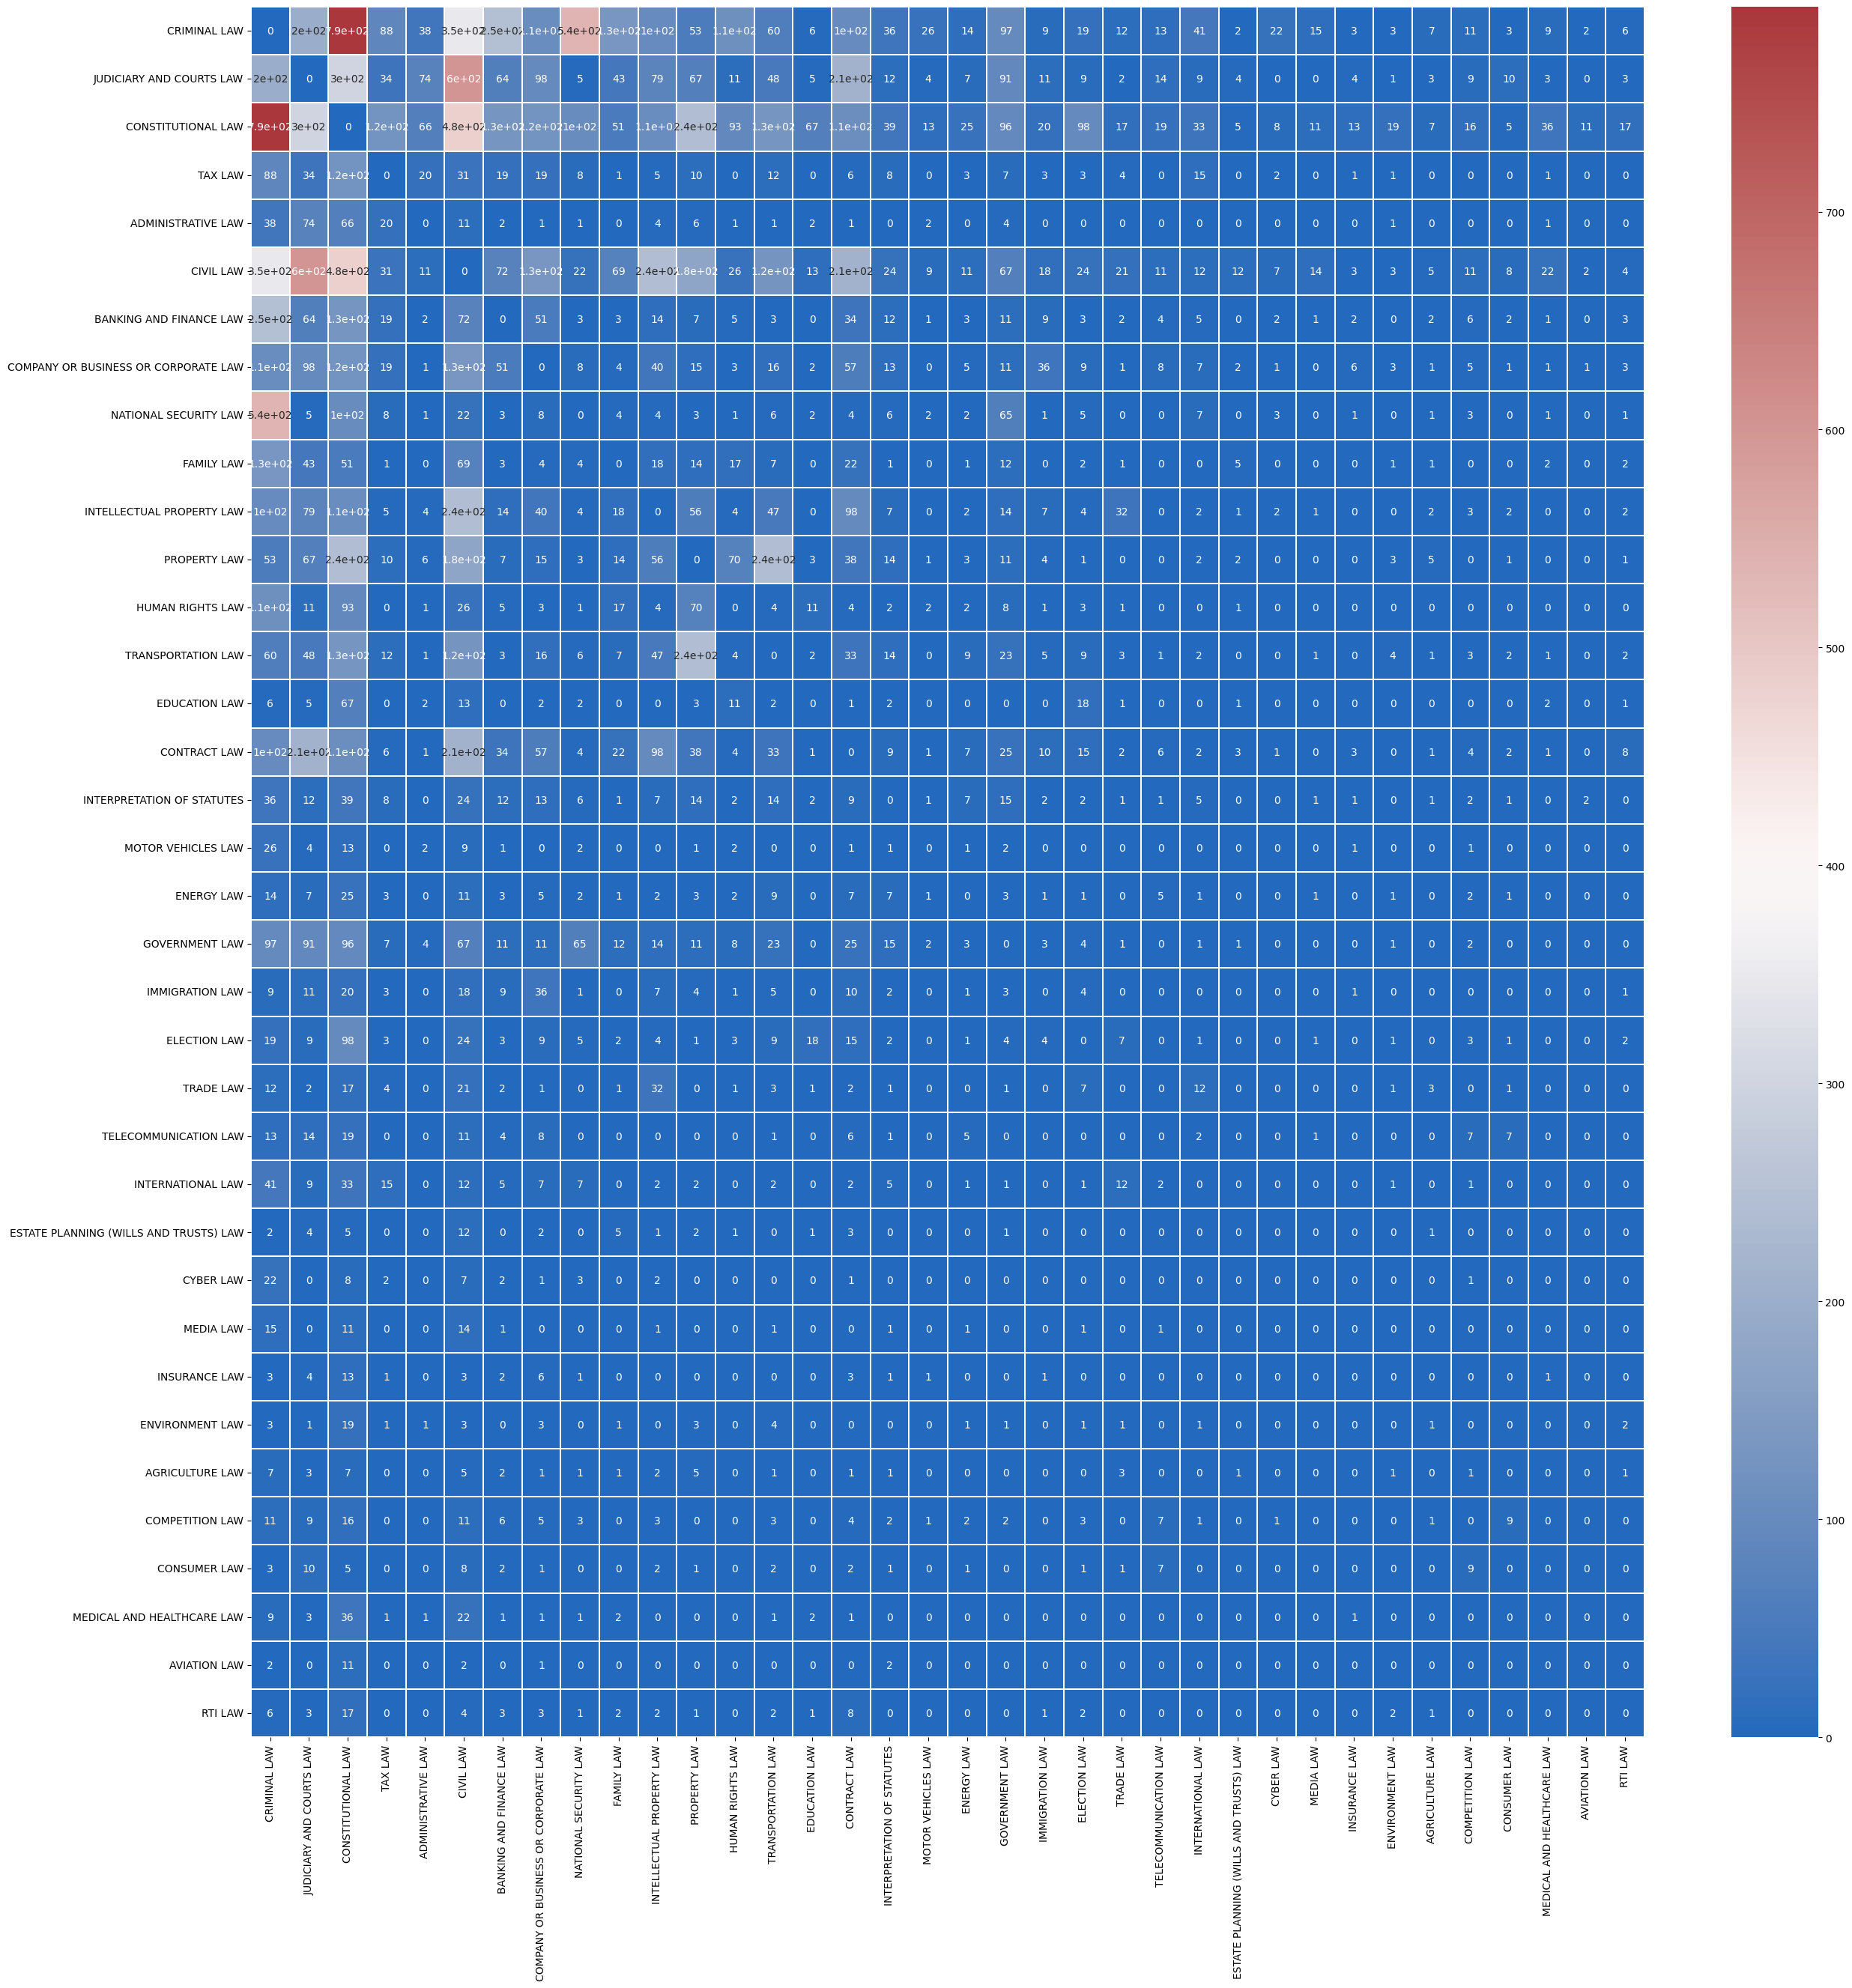

In [163]:
fig, ax = plt.subplots(figsize = (30,30))
sns.heatmap(df, cmap ='vlag', linewidths = 0.30, annot = True)
fig.savefig("area_cooccurence_heatmap.png")

## Analysing prediction results

### Frequency-based

In [108]:
with open("/home/workboots/Results/advocate_recommendation/exp_9/adv_pred_area_sim/vanilla/preds.json", 'r') as f:
    preds = json.load(f)

In [109]:
with open("/home/workboots/Results/advocate_recommendation/exp_9/adv_pred_area_sim/vanilla/test_f1.json", 'r') as f:
    metrics = json.load(f)

In [110]:
num_predicted = [len(v) for v in preds.values() if v != []]

In [111]:
sum(num_predicted) * 1./len(num_predicted)

1.4925068119891007

In [112]:
no_prediction = len([val for val in preds.values() if val == []])

In [113]:
no_prediction

1846

In [114]:
no_prediction_cases = [k for k, v in preds.items() if v == []]
prediction_cases = [k for k, v in preds.items() if v != []]

In [115]:
predicted_advs = list(chain.from_iterable(preds.values()))

In [116]:
predicted_advs = set(predicted_advs)

In [117]:
len(predicted_advs)

275

In [118]:
not_predicted_advs = set(adv_case_num.keys()) - predicted_advs

In [119]:
not_predicted_advs_case_num = {}

In [120]:
for adv in not_predict:
    not_predicted_advs_case_num[adv] = adv_case_num[adv]

NameError: name 'not_predict' is not defined

In [121]:
not_predicted_advs_case_num = {k: v for k, v in sorted(not_predicted_advs_case_num.items(), key=lambda x: x[1], reverse=True)}

In [122]:
predicted_advs_case_num = {}
for adv in predicted_advs:
    predicted_advs_case_num[adv] = adv_case_num[adv]

In [123]:
predicted_advs_case_num = {k: v for k, v in sorted(predicted_advs_case_num.items(), key=lambda x: x[1], reverse=True)}

The advocates not predicted show a low number of cases. However, advocates with a lower number of cases are predicted by the model as well.

In [124]:
advs_predicted_num = Counter(list(chain.from_iterable(preds.values())))

In [125]:
advs_predicted_num = {k: v for k, v in sorted(dict(advs_predicted_num).items(), key=lambda x: predicted_advs_case_num[x[0]], reverse=True)}

In [126]:
corr, _ = pearsonr(np.array(list(predicted_advs_case_num.values())), np.array(list(advs_predicted_num.values())))

In [127]:
corr

0.7743401962609312

The model shows very high correlation between the number of training cases and the number of times an advocate is predicted

In [128]:
all_advs_predicted_num = {adv: advs_predicted_num.get(adv, 0) for adv in selected_advs}
all_advs_predicted_num = {k: v for k, v in sorted(all_advs_predicted_num.items(), key=lambda x: x[1], reverse=True)}

In [988]:
adv_f1 = metrics["prec_rec_f1_sup"]["class_f1"]
adv_f1 = {k: v for k, v in sorted(adv_f1.items(), key=lambda x: all_advs_predicted_num[x[0]], reverse=True)}

In [989]:
corr, _ = pearsonr(np.array(list(all_advs_predicted_num.values())), np.array(list(adv_f1.values())))

In [990]:
corr

0.3816515685324142

Checking how many of the cases with no predictions have only advocates that were not predicted

In [991]:
no_prediction_low_freq_adv_cases = []

In [992]:
for case in no_prediction_cases:
    advs = set(case_advs[case]).intersection(set(selected_advs))
    common_advs = set(advs).intersection(not_predicted_advs)
    no_prediction_low_freq_adv_cases.append((len(advs), len(common_advs), len(common_advs) * 1./len(advs)))

The cases for which no advocates were predicted usually had a high number of targets

In [993]:
avg_num_targets_no_prediction_cases = [v[0] for v in no_prediction_low_freq_adv_cases]
avg_num_targets_no_prediction_cases = sum(avg_num_targets_no_prediction_cases) * 1./len(avg_num_targets_no_prediction_cases)

In [994]:
avg_num_targets_no_prediction_cases

1.8223185265438786

In [995]:
prediction_advs_num = []
for case in prediction_cases:
    advs = set(case_advs[case]).intersection(set(selected_advs))
    prediction_advs_num.append(len(advs))

In [996]:
avg_num_targets_prediction_cases = [v for v in prediction_advs_num]
avg_num_targets_prediction_cases = sum(avg_num_targets_prediction_cases) * 1./len(avg_num_targets_prediction_cases)

In [998]:
avg_num_targets_prediction_cases

2.018392370572207

The average number of advocates for cases with predicted advocates is 2.0.

In [999]:
avg_num_targets_no_prediction_cases_low_adv = [v[0] for v in no_prediction_low_freq_adv_cases if v[1] != 0]
avg_num_targets_no_prediction_cases_low_adv = sum(avg_num_targets_no_prediction_cases_low_adv) * 1./len(avg_num_targets_no_prediction_cases_low_adv)

In [1000]:
avg_num_targets_no_prediction_cases_low_adv

2.8009708737864076

For the cases in the test set with advocates from the set of advocates not predicted, the average number of advocates found was 5.0

Co-occurence of no prediction advocates with high frequency advocates

In [136]:
high_freq = 200
low_freq = 60

In [137]:
no_prediction_adv_cooccur_high_freq = defaultdict(int)
for case in case_advs:
    advs = set(case_advs[case]).intersection(set(selected_advs))
    common = set(advs).intersection(set(not_predicted_advs))
    if len(common) == 0:
        continue
    high_freq_advs = [adv for adv in advs if adv_case_num[adv] >= high_freq]
    if high_freq_advs != []:
        for adv_no_pred in common:
            no_prediction_adv_cooccur_high_freq[adv_no_pred] += 1

In [167]:
no_prediction_adv_cooccur_high_freq

defaultdict(int,
            {'OPManni': 12,
             'DKSharma': 4,
             'SGupta': 10,
             'RAIyer': 6,
             'PavanKumar': 3,
             'AmanLekhi': 12,
             'VKTandon': 18,
             'BalbirSingh': 4,
             'GovindKumar': 55,
             'ViplavAcharya': 2,
             'SantoshTripathi': 6,
             'PNBhardwaj': 12,
             'MukulRohtagi': 17,
             'SidhanthPanda': 10,
             'AMSinghvi': 14,
             'VijayJoshi': 7,
             'ManishSaroha': 4,
             'RoshanLalGoel': 3,
             'VirajDatar': 12,
             'RekhaPalli': 8,
             'RajeshGogna': 2,
             'BijiRajesh': 12,
             'ManishKumar': 9,
             'RahulSharma': 7,
             'SidharthAgarwal': 12,
             'GauravSharma': 9,
             'RajniGupta': 8,
             'SanjeevSindwani': 4,
             'PiyushSharma': 8,
             'ArvindKumarGupta': 5,
             'AbhayPrakashSahay': 1})

In [138]:
sum(no_prediction_adv_cooccur_high_freq.values()) * 1./len(no_prediction_adv_cooccur_high_freq.keys())

9.548387096774194

In [139]:
len(no_prediction_adv_cooccur_high_freq)

31

Of the 30 advocates that were not predicted, 29 advocates occurred with advocates with much higher cases

In [168]:
low_freq_advs = [adv for adv, num in adv_case_num.items() if num < low_freq and adv not in not_predicted_advs]
low_freq_adv_cooccur_high_freq = defaultdict(int)
for case in case_advs:
    advs = set(case_advs[case]).intersection(set(selected_advs))
    common = set(advs).intersection(set(low_freq_advs))
    if len(common) == 0:
        continue
    high_freq_advs = [adv for adv in advs if adv_case_num[adv] >= high_freq]
    if high_freq_advs != []:
        for adv_no_pred in common:
            low_freq_adv_cooccur_high_freq[adv_no_pred] += 1

The advocates with a low number of cases but which were predicted do not show a significant difference in number of cases with advocates with high number of cases

In [141]:
sum(low_freq_adv_cooccur_high_freq.values()) * 1./len(low_freq_adv_cooccur_high_freq.keys())

9.10738255033557

In [169]:
low_freq_adv_cooccur_high_freq

defaultdict(int,
            {'NavneetGoyal': 34,
             'SNPrashar': 17,
             'PradeepGaur': 9,
             'AtulNanda': 29,
             'SameerNadwani': 21,
             'RSingh': 9,
             'ArunYadav': 2,
             'PankajGupta': 5,
             'SumanBagga': 10,
             'BhupeshNarula': 13,
             'VinodDiwakar': 3,
             'MukeshGupta': 27,
             'SanjayKumar': 11,
             'PSharma': 5,
             'AnilGrover': 3,
             'AbhishekGupta': 6,
             'AnilSoni': 18,
             'RajeevMehra': 7,
             'AtulSharma': 4,
             'AbhishekSharma': 7,
             'SahajGarg': 50,
             'RipudamanBharwaj': 9,
             'NiteshKumarSingh': 47,
             'GaurangKant': 19,
             'VSingh': 13,
             'AbishekKumar': 6,
             'MohitGupta': 6,
             'GopalJain': 10,
             'SumeetPushkarna': 15,
             'NitiJain': 3,
             'VikramSaini': 15,
             '

### Area-Based

Average area argeement of non-target predictions with areas of cases

In [142]:
target_preds = {k: list((set(case_advs[k]).intersection(set(selected_advs))).intersection(set(v))) for k, v in preds.items() if v!= []}

In [143]:
non_target_preds = {k: list(set(v) - set(target_preds[k])) for k, v in preds.items() if v != []} 

In [144]:
non_target_advs = set(chain.from_iterable(non_target_preds.values()))

In [145]:
non_target_advs_case_num = [adv_case_num[adv] for adv in non_target_advs]

In [146]:
len(non_target_preds)

1468

In [147]:
non_target_preds_case_area_similarity = defaultdict(list)
for case, advs in non_target_preds.items():
    for adv in advs:
        adv_area = adv_info_train[adv]["areas"]
        case_area = case_areas.get(case, [])
        jaccard = len(set(adv_area).intersection(set(case_area))) * 1./len(case_area) if len(case_area) != 0 else 0
        non_target_preds_case_area_similarity[case].append(jaccard)

In [148]:
vals = list(chain.from_iterable(non_target_preds_case_area_similarity.values()))

In [149]:
avg_non_target_preds_case_area_similarity = sum(vals) * 1./len(vals)

In [150]:
avg_non_target_preds_case_area_similarity

0.022534967079068446

In [151]:
target_preds_case_area_similarity = defaultdict(list)
for case, advs in target_preds.items():
    for adv in advs:
        adv_area = adv_info_train[adv]["areas"]
        case_area = case_areas.get(case, [])
        jaccard = len(set(adv_area).intersection(set(case_area))) * 1./len(case_area) if len(case_area) !=0 else 0
        target_preds_case_area_similarity[case].append(jaccard)

In [152]:
vals = list(chain.from_iterable(target_preds_case_area_similarity.values()))

In [153]:
avg_target_preds_case_area_similarity = sum(vals) * 1./len(vals)

In [154]:
avg_target_preds_case_area_similarity

0.03438359669886764

In [155]:
len(vals)

812

Average area agreement between target_predictions and non-target predictions

In [156]:
target_preds_non_target_preds_area_similarity = defaultdict(list)
for case, advs in target_preds.items():
    non_target_advs = non_target_preds[case]
    for adv in advs:
        for non_pred_adv in non_target_advs:
            jaccard = len(set(adv_info_train[adv]["areas"]).intersection(set(adv_info_train[non_pred_adv]["areas"]))) * 1./len(set(adv_info_train[adv]["areas"]).union(set(adv_info_train[non_pred_adv]["areas"])))
            target_preds_non_target_preds_area_similarity[case].append(jaccard)

In [157]:
vals = list(chain.from_iterable(target_preds_non_target_preds_area_similarity.values()))

In [158]:
avg_target_preds_non_target_preds_area_similarity = sum(vals) * 1./len(vals)

In [159]:
avg_target_preds_non_target_preds_area_similarity

0.4882718380446265

Areas of no prediction advocates

In [160]:
not_predicted_advs_area_num = defaultdict(list)
for adv in not_predicted_advs:
    for area in adv_info_train[adv]["areas"]:
        not_predicted_advs_area_num[adv].append(area_num[area])

In [161]:
vals = list(chain.from_iterable(not_predicted_advs_area_num.values()))

In [162]:
avg_not_predicted_advs_area_num = sum(vals) * 1./len(vals)

In [163]:
avg_not_predicted_advs_area_num

861.3461538461538

In [164]:
vals = [len(v) for v in not_predicted_advs_area_num.values()]

In [165]:
sum(vals) * 1./len(vals)

11.741935483870968

Areas of predicted advocates

In [1054]:
predicted_advs_area_num = defaultdict(list)
for adv in predicted_advs:
    for area in adv_info_train[adv]["areas"]:
        predicted_advs_area_num[adv].append(area_num[area])

In [1055]:
vals = list(chain.from_iterable(predicted_advs_area_num.values()))

In [1056]:
avg_predicted_advs_area_num = sum(vals) * 1./len(vals)

In [1057]:
avg_predicted_advs_area_num

762.875197889182

In [1058]:
vals = [len(v) for v in predicted_advs_area_num.values()]

In [1059]:
sum(vals) * 1./len(vals)

13.781818181818181

In [166]:
predicted_low_freq_advs_area_num = defaultdict(list)
for adv in predicted_advs:
    if adv_case_num[adv] >= low_freq:
        continue
    for area in adv_info_train[adv]["areas"]:
        predicted_low_freq_advs_area_num[adv].append(area_num[area])

In [1061]:

vals = list(chain.from_iterable(predicted_low_freq_advs_area_num.values()))

In [1062]:
avg_predicted_low_freq_advs_area_num = sum(vals) * 1./len(vals)

In [1063]:
avg_predicted_low_freq_advs_area_num

855.9807268722467

In [1064]:
vals = [len(v) for v in predicted_low_freq_advs_area_num.values()]

In [1065]:
sum(vals) * 1./len(vals)

11.716129032258065

Correlation between predicted advocates and their win-ratios

In [66]:
case_winners_path = "/home/workboots/Datasets/DHC/variations/new/var_4/targets/dropped/case_adv_winners.json"

In [67]:
with open(case_winners_path, 'r') as f:
    case_winners = json.load(f)

In [91]:
adv_wins = defaultdict(lambda: set())
adv_cases = defaultdict(lambda: set())
for case, advs in case_winners.items():
    for adv in advs:
        adv_wins[adv].add(case)
    for adv in case_advs.get(case, ''):
        adv_cases[adv].add(case)

In [92]:
adv_win_percent = {k: len(adv_wins[k]) * 1./len(adv_cases[k]) for k in adv_cases.keys()}

In [97]:
adv_win_percent = {k: v for k, v in sorted(adv_win_percent.items(), key=lambda x: x[1], reverse=False)}

In [131]:
adv_win_percent

{'ItiJohri': 0.0,
 'JaspreetSinghRai': 0.0,
 'SanjayChauhan': 0.0,
 'RiteshThusu': 0.0,
 'RamandeepBawa': 0.0,
 'SuruchiMittal': 0.0,
 'SarkarThe': 0.0,
 'ACKarmakar': 0.0,
 'DinharTakiar': 0.0,
 'DeepabaliDatta': 0.0,
 'ViparnaGaur': 0.0,
 'SanjeevShai': 0.0,
 'SheshDattSharma': 0.0,
 'MukeshSaroja': 0.0,
 'WazirSinghMalik': 0.0,
 'DeepeshMakkad': 0.0,
 'LaxmiGupta': 0.0,
 'AshokGupta': 0.0,
 'RaghavMudgal': 0.0,
 'RKThakur': 0.0,
 'RishabhKrThakur': 0.0,
 'BalenduMishra': 0.0,
 'RajeevAwasthi': 0.0,
 'SomyaPandey': 0.0,
 'MonicaBenjamin': 0.0,
 'NKBeniwal': 0.0,
 'SougatMishra': 0.0,
 'SiddharthSunil': 0.0,
 'MeenakshiVerma': 0.0,
 'AmandeepKadyan': 0.0,
 'PratimaLakra': 0.0,
 'VijayKotwal': 0.0,
 'VarunSinghThapa': 0.0,
 'DhristiAhluwalia': 0.0,
 'GulabGupta': 0.0,
 'VinikaKiho': 0.0,
 'ChetnaBhati': 0.0,
 'SonalMadan': 0.0,
 'SShriram': 0.0,
 'VishnushreeDalmia': 0.0,
 'JugalBagga': 0.0,
 'DevanandaSingh': 0.0,
 'SamundraSain': 0.0,
 'AbhaySinghKushwaha': 0.0,
 'RajivRajpal': 0.0,


In [94]:
adv_cases["SSKaushal"]

{'158051477'}

In [95]:
adv_wins["SSKaushal"]

{'158051477'}

In [102]:
preds

{'86983856': [],
 '179901868': [],
 '156302810': ['DayanKrishan'],
 '29286494': ['MLYadav', 'ManjeetArya'],
 '180692420': ['PankajSeth'],
 '198741180': [],
 '196590036': [],
 '180791674': [],
 '54328508': [],
 '184702625': ['NareshKaushik'],
 '112497708': [],
 '51959344': ['KavitaJha'],
 '189305350': ['MohitMathur', 'PannaLalSharma'],
 '77612493': [],
 '191258377': ['RashmiChopra'],
 '159058213': ['SumeetPushkarna'],
 '109056021': [],
 '113705659': ['PravinAnand'],
 '77848441': ['MohitMathur', 'HirenSharma'],
 '196137557': [],
 '39635336': [],
 '1846710': ['AvnishAhlwat'],
 '135785164': ['SangeetaChandra', 'KirtiUppal'],
 '37432115': [],
 '37908004': [],
 '180040006': [],
 '89497932': ['SunilGoel'],
 '192915096': [],
 '143512641': [],
 '180226726': ['JyotiTyagi', 'YeshuJain'],
 '144463632': [],
 '154685132': [],
 '102036646': [],
 '3469970': [],
 '126736967': [],
 '129572526': [],
 '189912563': [],
 '26148186': ['MohinderRupal', 'ManinderAcharya', 'AmiteshKumar'],
 '151464361': [],
 '3

In [106]:
non_target_preds

{'156302810': ['DayanKrishan'],
 '29286494': [],
 '180692420': [],
 '184702625': ['NareshKaushik'],
 '51959344': ['KavitaJha'],
 '189305350': ['MohitMathur', 'PannaLalSharma'],
 '191258377': ['RashmiChopra'],
 '159058213': ['SumeetPushkarna'],
 '113705659': ['PravinAnand'],
 '77848441': ['HirenSharma'],
 '1846710': ['AvnishAhlwat'],
 '135785164': [],
 '89497932': [],
 '180226726': [],
 '26148186': ['MohinderRupal', 'AmiteshKumar', 'ManinderAcharya'],
 '113341109': ['KusumDhalla'],
 '100433786': [],
 '83120415': ['RakhiDubey'],
 '725727': ['RKSaini'],
 '22247981': ['AmiteshKumar'],
 '97821756': ['PremLataBansal', 'RashmiChopra', 'RameshGupta'],
 '22741206': ['RaviGupta', 'PawanSharma'],
 '53661538': ['SidharthLuthra'],
 '159627499': [],
 '165635592': ['RichaKapoor'],
 '164357807': ['MeenakshiChauhan'],
 '166703054': [],
 '125804647': ['PremLataBansal'],
 '149212445': ['VikasPahwa'],
 '180529770': ['RajatKatyal'],
 '24925191': ['PankajSeth'],
 '60369410': ['SanjaySingh'],
 '129910928': [

In [133]:
corr, _ = pearsonr(np.array(list(all_advs_predicted_num.values())), np.array([adv_win_percent.get(adv, 0) for adv in all_advs_predicted_num.keys()]))

In [134]:
corr

0.012640964604747297